In [213]:
%matplotlib inline
import nibabel as nib, nilearn as nil
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from nilearn import plotting
import pymc3 as pm
import theano.tensor as tt
import scipy as sp

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [2]:
network_templates = nib.load('OU_data/Masks/networks.nii')
network_list = pd.read_csv('OU_data/Masks/networks.csv')
print(network_list.values.flatten())

['DefaultMode.MPFC (1,55,-3)' 'DefaultMode.LP (L) (-39,-77,33)'
 'DefaultMode.LP (R) (47,-67,29)' 'DefaultMode.PCC (1,-61,38)'
 'SensoriMotor.Lateral (L) (-55,-12,29)'
 'SensoriMotor.Lateral (R) (56,-10,29)'
 'SensoriMotor.Superior  (0,-31,67)' 'Visual.Medial (2,-79,12)'
 'Visual.Occipital (0,-93,-4)' 'Visual.Lateral (L) (-37,-79,10)'
 'Visual.Lateral (R) (38,-72,13)' 'Salience.ACC (0,22,35)'
 'Salience.AInsula (L) (-44,13,1)' 'Salience.AInsula (R) (47,14,0)'
 'Salience.RPFC (L) (-32,45,27)' 'Salience.RPFC (R) (32,46,27)'
 'Salience.SMG (L) (-60,-39,31)' 'Salience.SMG (R) (62,-35,32)'
 'DorsalAttention.FEF (L)  (-27,-9,64)'
 'DorsalAttention.FEF (R)  (30,-6,64)'
 'DorsalAttention.IPS (L)  (-39,-43,52)'
 'DorsalAttention.IPS (R)  (39,-42,54)'
 'FrontoParietal.LPFC (L)  (-43,33,28)'
 'FrontoParietal.PPC (L)  (-46,-58,49)'
 'FrontoParietal.LPFC (R)  (41,38,30)'
 'FrontoParietal.PPC (R)  (52,-52,45)' 'Language.IFG (L) (-51,26,2)'
 'Language.IFG (R) (54,28,1)' 'Language.pSTG (L) (-57,-47,15

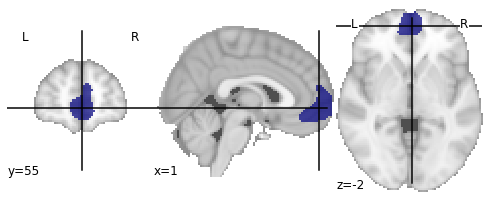

In [6]:
plotting.plot_roi(nil.image.index_img(network_templates,0)) #plotting mpfc

In [13]:
print('No of voxels in mpfc= ',np.count_nonzero(network_templates.get_fdata()[:,:,:,0]))

No of voxels in mpfc=  1346


In [114]:
subject_data = nib.load('OU_Data/Without Bandpass/niftiDATA_Subject001_Condition000.nii')
print(subject_data.shape) # there are 748 volumes/time-points
print(subject_data.header)

(91, 109, 91, 748)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  91 109  91 748   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'conn_matc2nii'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x 

In [73]:
nonzero_voxels = np.nonzero(network_templates.get_fdata()[:,:,:,0]) # indices of non-zero voxels in mpfc
mpfc_voxels = subject_data.get_fdata()[nonzero_voxels[0],nonzero_voxels[1],nonzero_voxels[2],:]

[39 39 39 ... 51 51 51]


In [14]:
print(mpfc_voxels.shape) # 1346 voxels with 748 timepoints each

(1346, 748)


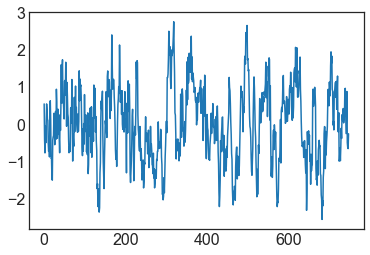

In [25]:
mpfc_mean = np.mean(mpfc_voxels,axis=0)
mpfc_std = mpfc_mean.std()
mpfc_norm = mpfc_mean/mpfc_std
plt.plot(mpfc_norm) #sample voxel timeseries

In [204]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult2(x1,0.802)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult2(x2,0.802)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)

In [18]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


In [52]:
print(OUanalytic2(mpfc_norm))
print(OUresult2(mpfc_norm,0.802))

(0.9952147393192616, 0.11884221105051038, 0.8290025765038899, 0.020331170772905728)
(0.9952147393192616, 0.11884221105051038, 4.276603097410993, 0.5592809566497965)


In [31]:
mpfc_voxels_std = np.std(mpfc_voxels,axis=1)
mpfc_voxels_std.shape
mpfc_voxels_norm = (mpfc_voxels.T/mpfc_voxels_std).T

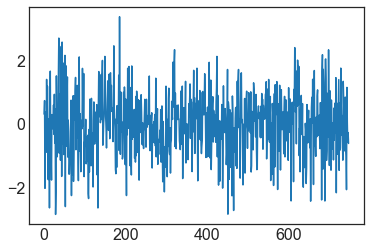

In [43]:
plt.plot(mpfc_voxels_norm[500])

In [53]:
a_bound=1
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=a_bound*2)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(mpfc_norm))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=mpfc_norm)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:18<00:00, 540.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [54]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],0.399,0.205,0.001,0.770,0.003,0.002,5511.0,5511.0,5697.0,4607.0,1.00
path[1],-0.332,0.194,-0.705,0.023,0.002,0.002,8584.0,7186.0,8601.0,4510.0,1.00
path[2],-0.639,0.198,-1.007,-0.266,0.003,0.002,5260.0,5260.0,5492.0,3953.0,1.00
path[3],-0.173,0.190,-0.550,0.167,0.002,0.002,8443.0,3744.0,8516.0,5387.0,1.00
path[4],-0.396,0.194,-0.769,-0.041,0.002,0.001,9307.0,9207.0,9596.0,5008.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
path[746],-0.601,0.190,-0.945,-0.235,0.002,0.001,10234.0,9890.0,10206.0,4667.0,1.00
path[747],-0.309,0.198,-0.686,0.063,0.002,0.002,9133.0,6014.0,9246.0,5233.0,1.00
B,0.862,0.017,0.831,0.893,0.001,0.001,513.0,513.0,526.0,1162.0,1.01
A,0.889,0.073,0.764,1.000,0.001,0.001,3585.0,3482.0,2952.0,2421.0,1.00


In [70]:
print(0.889/0.218**2)

18.7063378503493


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2d56ffa90>,
      dtype=object)

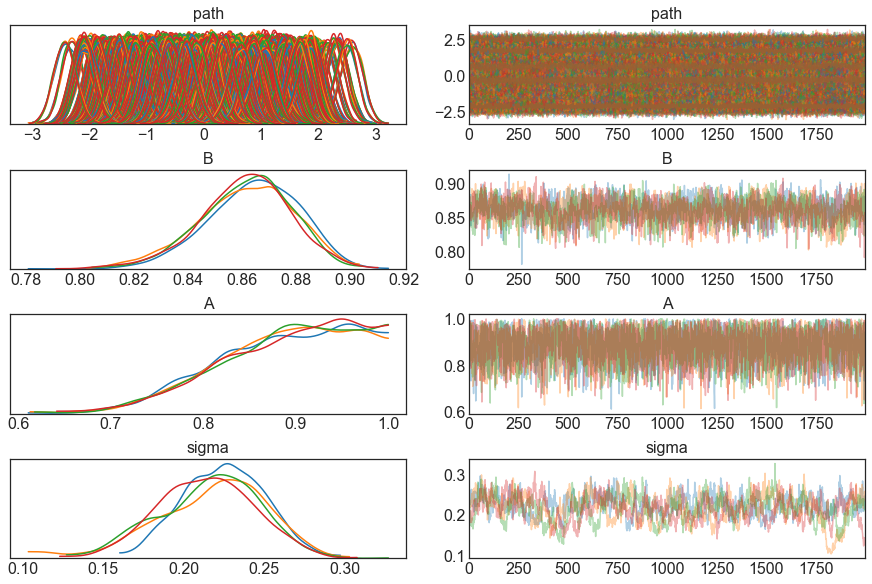

In [55]:
pm.traceplot(trace)

In [56]:
delta_t=0.802
tau = -delta_t/np.log(np.mean(trace['B']))
dtau = delta_t*np.std(trace['B'])/np.mean(trace['B'])/np.log(np.mean(trace['B']))**2
print(tau,dtau)

5.395540817145035 0.7109825011672871


In [63]:
# lets construct a beta distribution for B that reflects this value and standard deviation
# mean = alpha/(alpha+beta)
# variance = alpha*beta/(alpha+beta)^2/(alpha+beta+1)= mean^2*beta/(alpha+beta+1)/alpha
B_mean = np.mean(trace['B'])
B_var = 5*np.std(trace['B'])**2
alp = B_mean**2*(1-B_mean)/B_var-B_mean
bet = alp/B_mean -alp
print(B_mean,B_var,alp,bet)

0.8618782473239206 0.0014249134148357743 71.14358439757139 11.401235150279916


In [64]:
a_bound=1
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=alp,beta=bet)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=a_bound*2)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(mpfc_voxels_norm[500]))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=mpfc_voxels_norm[500])
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:15<00:00, 131.88draws/s]
The acceptance probability does not match the target. It is 0.6142632747761884, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [65]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],-0.020,0.227,-0.451,0.418,0.002,0.004,10934.0,1341.0,11003.0,4597.0,1.01
path[1],-0.031,0.221,-0.455,0.390,0.002,0.004,11888.0,1394.0,12010.0,3832.0,1.01
path[2],-0.058,0.219,-0.493,0.338,0.002,0.004,11340.0,1553.0,11482.0,4148.0,1.00
path[3],-0.046,0.217,-0.470,0.354,0.002,0.003,11956.0,1963.0,11994.0,5304.0,1.00
path[4],-0.046,0.213,-0.457,0.343,0.002,0.003,11239.0,2460.0,11355.0,6166.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
path[746],-0.103,0.223,-0.522,0.313,0.002,0.004,8711.0,1369.0,8891.0,4351.0,1.01
path[747],-0.096,0.228,-0.552,0.313,0.003,0.004,7933.0,2100.0,8132.0,4888.0,1.00
B,0.863,0.035,0.798,0.926,0.003,0.002,157.0,155.0,151.0,807.0,1.03
A,0.066,0.029,0.017,0.120,0.005,0.003,42.0,42.0,39.0,191.0,1.09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e6d3db00>,
      dtype=object)

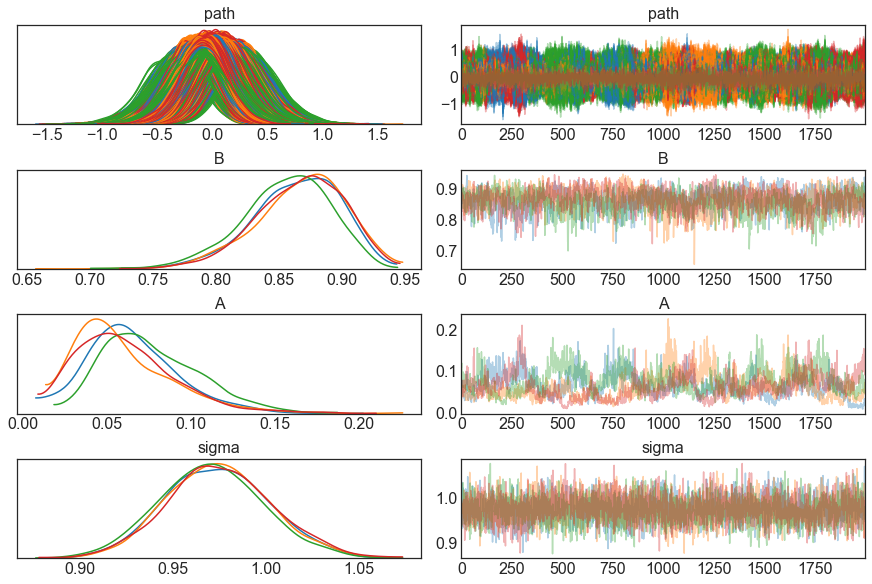

In [66]:
pm.traceplot(trace)

In [67]:
print(0.066/0.973**2)

0.06971371955438146


In [71]:
# signal to noise for the average of 1376 voxels
print(0.066/0.973**2*1376)

95.9260781068289


In [195]:
# voxel-voxel correlation
def distance(voxel1,voxel2):
    return np.sqrt((voxel1[0]-voxel2[0])**2 + (voxel1[1]-voxel2[1])**2 + (voxel1[2]-voxel2[2])**2)

voxels = np.vstack((nonzero_voxels[0],nonzero_voxels[1],nonzero_voxels[2])).T

voxel_dist = []
for i in range(len(voxels)):
    for j in range(i+1,len(voxels)):
        voxel_dist.append([voxels[i],voxels[j],i,j,distance(voxels[i],voxels[j])])

In [196]:
voxel_dist_sort = sorted(voxel_dist, key=lambda x: x[-1])

In [197]:
def centerofmass(x,y,z):
    return np.array([np.sum(x),np.sum(y),np.sum(z)])/len(x)

In [198]:
com = centerofmass(nonzero_voxels[0],nonzero_voxels[1],nonzero_voxels[2])
print(com)

[44.4435364  90.66344725 34.55720654]


In [199]:
for i in range(1700,1750):
    print(i,voxel_dist_sort[i])

1700 [array([44, 90, 38]), array([44, 90, 39]), 625, 626, 1.0]
1701 [array([44, 90, 38]), array([44, 91, 38]), 625, 639, 1.0]
1702 [array([44, 90, 38]), array([45, 90, 38]), 625, 791, 1.0]
1703 [array([44, 90, 39]), array([44, 91, 39]), 626, 640, 1.0]
1704 [array([44, 90, 39]), array([45, 90, 39]), 626, 792, 1.0]
1705 [array([44, 90, 43]), array([44, 90, 44]), 627, 628, 1.0]
1706 [array([44, 90, 43]), array([44, 91, 43]), 627, 644, 1.0]
1707 [array([44, 90, 44]), array([44, 90, 45]), 628, 629, 1.0]
1708 [array([44, 90, 44]), array([44, 91, 44]), 628, 645, 1.0]
1709 [array([44, 90, 45]), array([44, 91, 45]), 629, 646, 1.0]
1710 [array([44, 91, 29]), array([44, 91, 30]), 630, 631, 1.0]
1711 [array([44, 91, 29]), array([44, 92, 29]), 630, 647, 1.0]
1712 [array([44, 91, 29]), array([45, 91, 29]), 630, 793, 1.0]
1713 [array([44, 91, 30]), array([44, 91, 31]), 631, 632, 1.0]
1714 [array([44, 91, 30]), array([44, 92, 30]), 631, 648, 1.0]
1715 [array([44, 91, 30]), array([45, 91, 30]), 631, 79

In [200]:
voxel_test = voxel_dist_sort[1726]
print(voxel_test[0],voxel_test[2])
print(voxel_test[1],voxel_test[3])

[44 91 34] 635
[44 92 34] 652


In [206]:
voxel1_ts = mpfc_voxels_norm[voxel_test[2]]
voxel2_ts = mpfc_voxels_norm[voxel_test[3]]
voxelplus = voxel1_ts + voxel2_ts
voxelminus = voxel1_ts - voxel2_ts

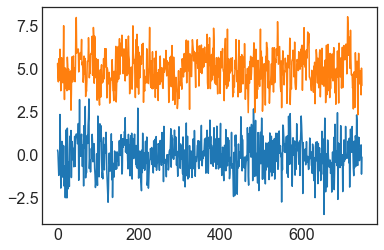

In [226]:
plt.plot(voxel1_ts)
plt.plot(voxel2_ts+5)

In [214]:
print(OUcross(voxel1_ts,voxel2_ts))
print("Pearson voxel1:voxel2",sp.stats.pearsonr(voxel1_ts,voxel2_ts))

(0.866554692651244, 0.1713657655217315)
Pearson voxel1:voxel2 (0.3022950069738569, 2.854900274349951e-17)


In [209]:
a_bound=1
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=alp,beta=bet)
    A1 = pm.Uniform('A1', lower=0, upper=a_bound)
    A2 = pm.Uniform('A2', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=a_bound*2)

    path1 = Ornstein_Uhlenbeck('path1',A=A1, B=B,shape=len(voxelplus))
    path2 = Ornstein_Uhlenbeck('path2',A=A2, B=B,shape=len(voxelminus))
    dataObs1 = pm.Normal('dataObs1',mu=path1,sigma=sigma,observed=voxelplus)
    dataObs2 = pm.Normal('dataObs2',mu=path2,sigma=sigma,observed=voxelminus)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path2, path1, sigma, A2, A1, B]
Sampling 4 chains, 10 divergences: 100%|██████████| 10000/10000 [01:01<00:00, 162.82draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5791097428441258, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050607202849648, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [210]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path1[0],-0.034,0.645,-1.257,1.165,0.006,0.007,10308.0,4813.0,10326.0,6412.0,1.00
path1[1],-0.193,0.603,-1.283,0.993,0.006,0.006,9598.0,4330.0,9657.0,5704.0,1.00
path1[2],-0.364,0.594,-1.474,0.766,0.006,0.006,9484.0,5241.0,9440.0,6805.0,1.00
path1[3],-0.340,0.589,-1.460,0.718,0.006,0.006,9622.0,5068.0,9655.0,6487.0,1.00
path1[4],-0.278,0.591,-1.368,0.824,0.006,0.006,9829.0,5653.0,9853.0,6577.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
path2[747],0.173,0.385,-0.555,0.881,0.004,0.004,9960.0,4948.0,9914.0,6904.0,1.00
B,0.791,0.041,0.714,0.867,0.003,0.002,172.0,169.0,169.0,191.0,1.04
A1,0.835,0.116,0.628,1.000,0.006,0.004,350.0,350.0,398.0,605.0,1.01
A2,0.196,0.058,0.094,0.313,0.005,0.004,119.0,119.0,110.0,257.0,1.04


In [211]:
A1 = np.mean(trace['A1'])
A2 = np.mean(trace['A2'])
dA1 = np.std(trace['A1'])
dA2 = np.std(trace['A2'])

In [212]:
print((A1-A2)/A2)
print(np.sqrt(dA1**2+dA1**2*dA2**2/A2**4))

3.250306124078775
0.2102395063532669


In [230]:
avgpathplus = np.mean(trace['path1'],axis=0)
stdpathplus = np.std(trace['path1'],axis=0)
print(avgpathplus.shape)
avgpathplus_norm=avgpathplus/np.std(avgpathplus)

(748,)


In [231]:
avgpathminus = np.mean(trace['path2'],axis=0)
stdpathminus = np.std(trace['path2'],axis=0)
print(avgpathminus.shape)
avgpathminus_norm=avgpathminus/np.std(avgpathminus)

(748,)


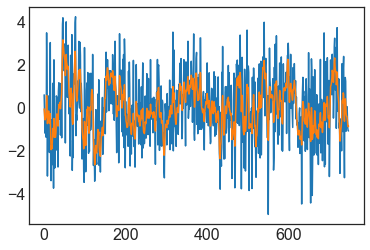

In [232]:
plt.plot(voxelplus)
plt.plot(avgpathplus_norm)

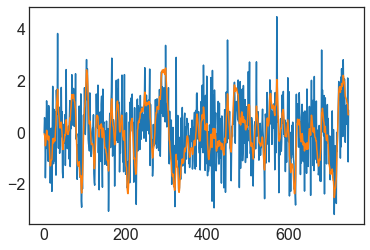

In [233]:
plt.plot(voxelminus)
plt.plot(avgpathminus_norm)

In [235]:
avgpath1 = (avgpathplus+avgpathminus)/2
avgpath2 = (avgpathplus-avgpathminus)/2
avgpath1_norm = avgpath1/np.std(avgpath1)
avgpath2_norm = avgpath2/np.std(avgpath2)
print(OUcross(avgpath1_norm,avgpath2_norm))
print("Pearson voxel1:voxel2",sp.stats.pearsonr(avgpath1,avgpath2))

(5.686784131629199, 1.8666071545311052)
Pearson voxel1:voxel2 (0.7350500267944551, 5.036389610626543e-128)


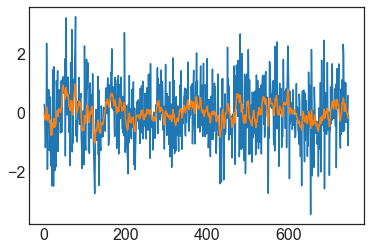

In [236]:
plt.plot(voxel1_ts)
plt.plot(avgpath1)

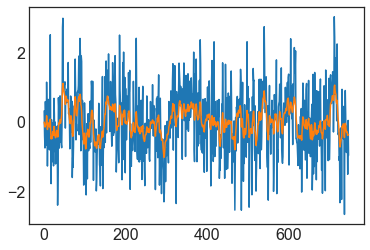

In [237]:
plt.plot(voxel2_ts)
plt.plot(avgpath2)